In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

## Tree Survival Prediction

In [2]:
df = pd.read_csv('../../data/diffrent/Tree_Data.csv')
df_clean = df.drop(['No',
                    'Light_Cat',
                    'Core',
                    'PlantDate',
                    'Adult',
                    'EMF',
                    'Census',
                    'Harvest',
                    'Alive',
                    'Time'],axis = 1)
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)
df_clean['Plot'] = df_clean['Plot'].astype('object')
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Plot         2782 non-null   object 
 1   Subplot      2782 non-null   object 
 2   Species      2782 non-null   object 
 3   Light_ISF    2782 non-null   float64
 4   Soil         2782 non-null   object 
 5   Sterile      2782 non-null   object 
 6   Conspecific  2782 non-null   object 
 7   Myco         2782 non-null   object 
 8   SoilMyco     2782 non-null   object 
 9   AMF          2782 non-null   float64
 10  Phenolics    2782 non-null   float64
 11  Lignin       2782 non-null   float64
 12  NSC          2782 non-null   float64
 13  Event        2782 non-null   float64
dtypes: float64(6), object(8)
memory usage: 304.4+ KB


,Plot,Subplot,Species,Light_ISF,Soil,Sterile,Conspecific,Myco,SoilMyco,AMF,Phenolics,Lignin,NSC,Event
0,1,C,Acer saccharum,0.106,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,22.00,-0.56,13.86,12.15,1.0
1,1,C,Quercus alba,0.106,Quercus rubra,Non-Sterile,Heterospecific,EMF,EMF,15.82,5.19,20.52,19.29,0.0
2,1,C,Quercus rubra,0.106,Prunus serotina,Non-Sterile,Heterospecific,EMF,AMF,24.45,3.36,24.74,15.01,1.0
3,7,D,Acer saccharum,0.080,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,22.23,-0.71,14.29,12.36,1.0
4,14,A,Acer saccharum,0.060,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,21.15,-0.58,10.85,11.20,1.0


In [3]:
# The number of unique values per column
print(df_clean.nunique())

Plot             18
Subplot           5
Species           4
Light_ISF        53
Soil              7
Sterile           2
Conspecific       3
Myco              2
SoilMyco          3
AMF             923
Phenolics       494
Lignin         1094
NSC             998
Event             2
dtype: int64


### Data preprocessing

In [4]:
preprocessing = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))
)

In [5]:
X, y = df_clean.iloc[:, :-1], df_clean.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessing.fit_transform(X_train).toarray()
X_test = preprocessing.transform(X_test).toarray()

y_train, y_test = y_train.values, y_test.values

In [6]:
print(f"Train data shape = {X_train.shape}, train target shape = {y_train.shape}")
print(f"Test data shape = {X_test.shape}, test target shape = {y_test.shape}")

Train data shape = (2225, 49), train target shape = (2225, 1)
Test data shape = (557, 49), test target shape = (557, 1)


### Data  pre-analysis

Most correlated features' indicies:
[(2, 44), (2, 45), (3, 44), (3, 45), (38, 39), (38, 40), (38, 43), (38, 48), (39, 40), (39, 43), (39, 48), (40, 43), (40, 48), (43, 48), (44, 45)]
Most correlated with target features:
[2, 3, 4, 28, 30, 31, 44, 45]


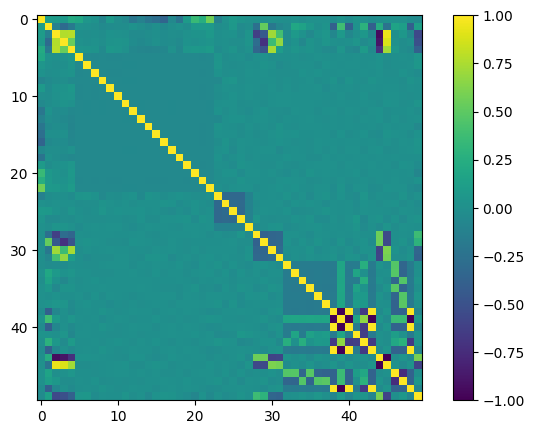

In [7]:
# Сorrelation of features with each other and with target
corrcoeffs = np.corrcoef(np.hstack([X_train, y_train]), rowvar=False)

thresh_f, thresh_t = 0.85, 0.3
idxs_features = np.argwhere(np.abs(np.triu(corrcoeffs[:, :-1], k=1)) > thresh_f)
print(f"Most correlated features' indicies:\n{[(f_i, f_j) for f_i, f_j in idxs_features]}")
idxs_corr = np.argwhere(np.abs(corrcoeffs[:-1, -1]) > thresh_t).flatten().tolist()
print(f"Most correlated with target features:\n{idxs_corr}")

plt.figure(figsize=(8, 5))
plt.imshow(corrcoeffs, cmap='viridis')
plt.colorbar()


Fetures with highest ANOVA F-value 
[ 0  1  2  3  4 31 44 45]


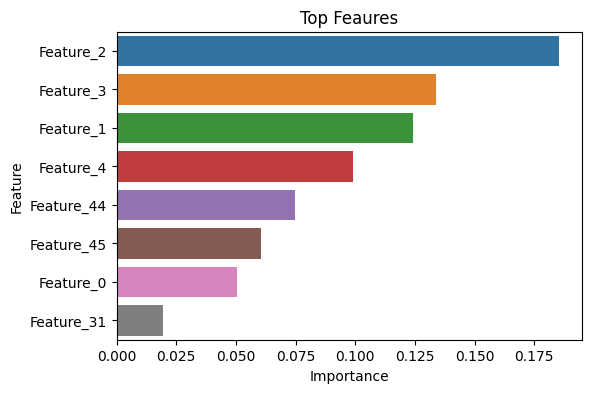

In [8]:
# ANOVA F-value test importences
pipeline_fval = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=49)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_fval.fit(X_train, y_train.flatten())
importances = pipeline_fval.named_steps['classifier'].feature_importances_
feature_names = [f'Feature_{f_i}' for f_i in range(49)]

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
idxs_fval = np.sort(np.argpartition(feature_importances['importance'].values, -len(idxs_corr))[-len(idxs_corr):])
feature_importances = feature_importances.sort_values(by='importance', ascending=False)[:len(idxs_corr)]

print(f'Fetures with highest ANOVA F-value \n{idxs_fval}')
plt.figure(figsize=(6, 4))
sns.barplot(x='importance', y='feature', data=feature_importances.head(19))
plt.title('Top Feaures')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

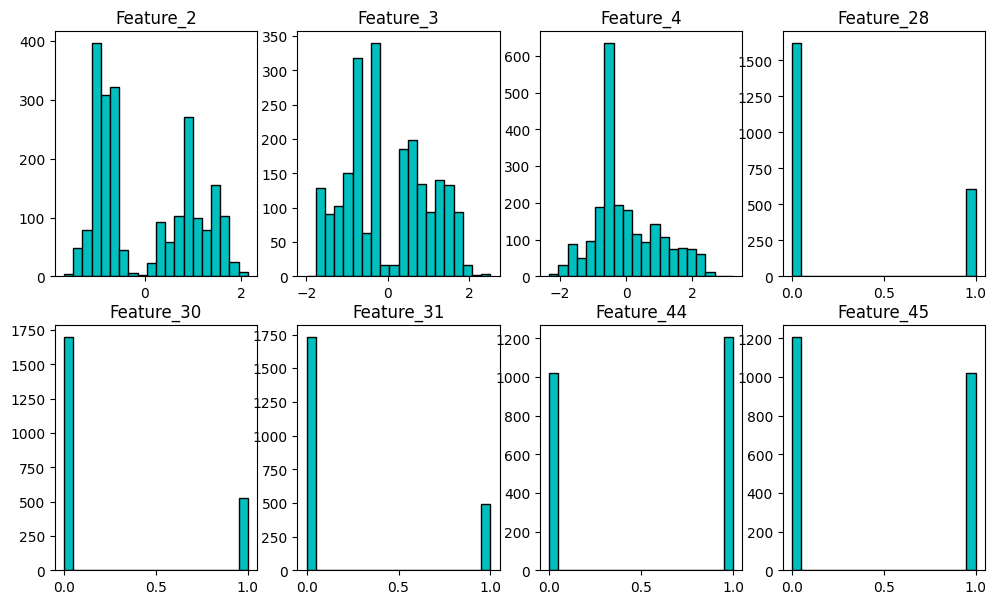

In [9]:
# Features' distributions
plt.figure(figsize=(12, 7))
for k, feature_k in enumerate(idxs_corr):
    plt.subplot(2, 4, k + 1)
    plt.title(f'Feature_{feature_k}')
    plt.hist(X_train[:, feature_k].flatten(), bins=20, color='c', edgecolor='k')
plt.show()

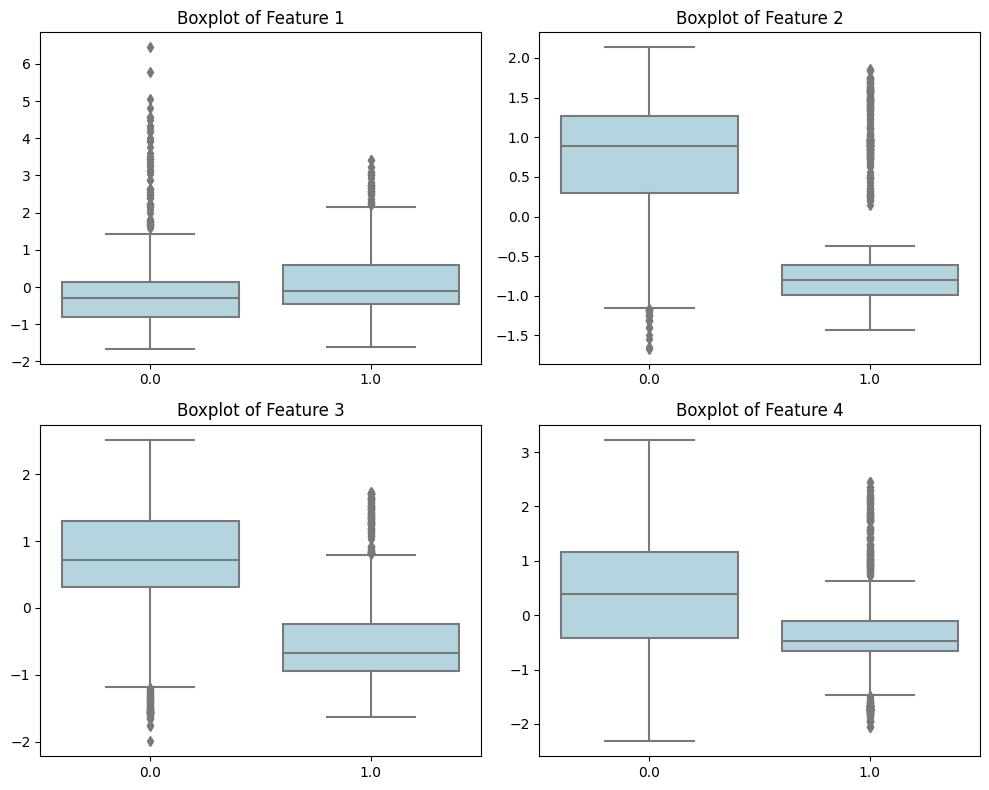

In [10]:
plt.figure(figsize=(10, 8))
for i, feature in enumerate([1, 2, 3, 4]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=y_train.flatten(), y=X_train[:, feature].flatten(), color='lightblue')
    plt.title(f'Boxplot of Feature {feature}')
plt.tight_layout()
plt.show()

In [11]:
# Get rid of non-correlated data
X_train, X_test = X_train[:, idxs_fval], X_test[:, idxs_fval]
y_train, y_test = y_train.flatten(), y_test.flatten()

### Taining a classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
classifiers = {
    'KNeighborsClassifier': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}),
    'DecisionTreeClassifier': (DecisionTreeClassifier(), {'max_depth': [3, 5, 10, None], 'criterion': ['gini', 'entropy']}),
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}),
    'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10, None]}),
    'AdaBoostClassifier': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]})
}

for clf_name, (clf, params) in classifiers.items():
    print(f"Processing {clf_name}...")
    
    grid_search = GridSearchCV(clf, params, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    print(f"Best parameters for {clf_name}: {best_params}")
    
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score for {clf_name}: {round(f1, 4)}\n")
    

Processing KNeighborsClassifier...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 9, 'weights': 'uniform'}
F1-Score for KNeighborsClassifier: 0.8523

Processing DecisionTreeClassifier...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10}
F1-Score for DecisionTreeClassifier: 0.8543

Processing SVC...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for SVC: {'C': 10, 'kernel': 'rbf'}
F1-Score for SVC: 0.8557

Processing RandomForestClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50}
F1-Score for RandomForestClassifier: 0.8786

Processing AdaBoostClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for AdaBoostClassifier: {'learning_rate': 1, 'n_estimators': 

In [14]:
rf_clf = RandomForestClassifier(max_depth=None, n_estimators=200)

rf_clf.fit(X_train, y_train.ravel())

y_pred = rf_clf.predict(X_test)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.84       234
         1.0       0.88      0.89      0.88       323

    accuracy                           0.86       557
   macro avg       0.86      0.86      0.86       557
weighted avg       0.86      0.86      0.86       557

Confusion Matrix:
 [[195  39]
 [ 37 286]]


### ML algorithms from scratch

In [15]:
from my_svm import MySVM
from my_random_forest import MyRandomForest

In [30]:
my_svm = MySVM(X_len=len(X_train[:250]), C=10)
my_svm.fit(X_train[:250], y_train[:250])

y_pred = my_svm.predict(X_test)
print('F1 score =', f1_score(y_test, y_pred))

F1 score = 0.8120300751879699


In [27]:
my_rf = MyRandomForest(max_depth=10, trees_number=25)
my_rf.fit(X_train, y_train)

y_pred = my_rf.predict(X_test)
print('F1 score =', f1_score(y_test, y_pred))

F1 score = 0.8431372549019608
